In [50]:
#Create a model that takes a 20x20 image and is able to do INR on it. Try first just creating hyperresolution image of 40x40, then try to use techniques to aid with spectral bias
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The image resolution is: 2316x2674


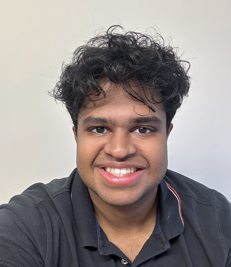

In [72]:
# Load image with PIL
image = Image.open("./headshot.jpg").convert("RGB")

width, height = image.size

image = image.resize((width//10, height//10))

# Print the dimensions
print(f"The image resolution is: {width}x{height}")
image

In [73]:
rgb_array = np.array(image)  # shape: (H, W, 3)

height, width = rgb_array.shape[:2]
print(f"The image resolution is: {width}x{height}")

# Create coordinate grids
x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

# Flatten everything
x_flat = x_coords.ravel()
y_flat = y_coords.ravel()
r_flat = rgb_array[:, :, 0].ravel()
g_flat = rgb_array[:, :, 1].ravel()
b_flat = rgb_array[:, :, 2].ravel()

# Create the DataFrame in one go
df = pd.DataFrame({
    "x_pos": x_flat/(width-1),
    "y_pos": y_flat/(height-1),
    "R": r_flat/np.max(r_flat),
    "G": g_flat/np.max(g_flat),
    "B": b_flat/np.max(b_flat)
})

df[100:120]

The image resolution is: 231x267


,x_pos,y_pos,R,G,B
100,0.434783,0.0,0.870079,0.872,0.843373
101,0.439130,0.0,0.870079,0.872,0.843373
102,0.443478,0.0,0.870079,0.872,0.847390
103,0.447826,0.0,0.870079,0.872,0.847390
104,0.452174,0.0,0.870079,0.872,0.847390
105,0.456522,0.0,0.870079,0.872,0.847390
106,0.460870,0.0,0.874016,0.876,0.851406
107,0.465217,0.0,0.874016,0.876,0.851406
108,0.469565,0.0,0.874016,0.876,0.851406
109,0.473913,0.0,0.870079,0.872,0.847390


In [135]:
class ImageINRModel(torch.nn.Module):

    def __init__(self, input_size):
        super(ImageINRModel, self).__init__()

        self.input = torch.nn.Linear(input_size, 256)
        self.l1 = torch.nn.Linear(256, 256)
        self.l2 = torch.nn.Linear(256, 256)
        self.l3 = torch.nn.Linear(256, 256)
        self.l4 = torch.nn.Linear(256, 256)
        self.output = torch.nn.Linear(256, 3)

        self.activation = torch.nn.ReLU()
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.l1(x)
        x = self.activation(x)
        x = self.l2(x)
        x = self.activation(x)
        x = self.l3(x)
        x = self.activation(x)
        x = self.l4(x)
        x = self.activation(x)
        x = self.output(x)
        x = self.sig(x)

        return x

In [136]:
class ImageINRDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe[['R', 'G', 'B']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [152]:
class ImageINRDatasetBasicFourier(Dataset):
    def __init__(self, dataframe, fourier = False, gaussian = False, num_freq = 1, freq_param = None, freq_file = 'freq.pkl', gauss_scale = 1):
        self.dataframe = dataframe
        
        if (fourier or gaussian) == False:
            print('here')
            self.x = torch.tensor(dataframe[['x_pos', 'y_pos']].values, dtype=torch.float32)
        else:
            if fourier == True:
                #print('here')
                freq = [1, 1]
            elif gaussian == True:
                freq = np.random.normal(0, 1, size = num_freq*2)*gauss_scale
                pickle.dump(freq, open(freq_file, "wb"))
            else:
                freq = freq_param
                
            pos = []
            x = dataframe['x_pos']
            y = dataframe['y_pos'] 
            
            xy = torch.tensor(np.stack([x, y], axis=-1), dtype = torch.float32)
            
            self.x = fourier_encode(xy, freq)
            print('here')
                         
        self.y = torch.tensor(dataframe[['R', 'G', 'B']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [153]:
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:

    # Expand: (N, 2) → (N, 1, 2)
    xy = xy.unsqueeze(1)  # shape: (N, 1, 2)

    # (F,) → (1, F, 1), for broadcasting

    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]
    
    
    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    # Multiply and encode
    scaled1 = 2 * torch.pi * (1/freq1) * xy  # shape: (N, F, 2)
    scaled2 = 2 * torch.pi * (1/freq2) * xy  # shape: (N, F, 2)

    sin_feat = torch.sin(scaled1)  # (N, F, 2)
    cos_feat = torch.cos(scaled2)  # (N, F, 2)

    # Concatenate and flatten last two dimensions: (N, F, 4) → (N, 4 * F)
    features = torch.cat([sin_feat, cos_feat], dim=-1)  # (N, F, 4)
    return features.view(xy.shape[0], -1)  # (N, 4 * F)

In [64]:
import pickle
data = ImageINRDataset(df)
data2 = ImageINRDatasetBasicFourier(df, gaussian = True, num_freq = 10)
print(data2[20])
train_dataloader = DataLoader(data2, batch_size=8192, shuffle=True)

freq is + [-1.72474619e-03 -9.83628345e-01 -1.86611479e+00 -8.77265984e-01
  9.61056968e-01 -4.48572076e-01  1.02813581e+00 -1.18804318e+00
  2.01377803e+00 -5.98231936e-01 -1.42209016e+00 -3.80877348e-01
  1.20906123e+00 -4.15895405e-03  1.55084244e+00 -2.42930258e-01
 -1.47914279e+00 -1.25100896e+00  3.75472633e-01 -2.56536525e-01]
[-1.72474619e-03 -9.83628345e-01 -1.86611479e+00 -8.77265984e-01
  9.61056968e-01 -4.48572076e-01  1.02813581e+00 -1.18804318e+00
  2.01377803e+00 -5.98231936e-01]
[-1.42209016 -0.38087735  1.20906123 -0.00415895  1.55084244 -0.24293026
 -1.47914279 -1.25100896  0.37547263 -0.25653653]
(tensor([ 0.1540, -0.0000,  0.9572,  1.0000, -0.4118, -0.0000,  0.4571,  1.0000,
        -0.2219, -0.0000,  0.9410,  1.0000, -0.4581, -0.0000,  0.9890,  1.0000,
         0.4209,  0.0000,  0.9640,  1.0000, -0.8020, -0.0000, -0.1472,  1.0000,
         0.3950,  0.0000,  0.9604,  1.0000, -0.3442, -0.0000,  0.9448,  1.0000,
         0.2058,  0.0000,  0.4430,  1.0000, -0.6426, -0.

In [150]:
from tqdm import tqdm
import pickle
def train( num_freq, model_type, out_file = 'checkpoint.pth', loss_file = 'losses', freq_file = 'freq.pkl', gauss_scale = 1):
    epoch_losses = []
    min_loss = 100
    
    if model_type == 'fourier':
        data = ImageINRDatasetBasicFourier(df, fourier = True, num_freq = 1)
        model = ImageINRModel(input_size = 4).to(device)
    elif model_type == 'standard':
        data = ImageINRDataset(df)
        model = ImageINRModel(input_size = 2).to(device)
    elif model_type == 'gaussian':
        data = ImageINRDatasetBasicFourier(df, gaussian = True, num_freq = num_freq, freq_file = freq_file, gauss_scale = gauss_scale)
        model = ImageINRModel(input_size = 4*num_freq).to(device)
    elif model_type == 'STAF':
        data = ImageINRDataset(df)
        model = INR(2, 256, 4, 3).to(device)
    else:
        print('invalid model_type')
        return
    
    train_dataloader = DataLoader(data, batch_size=8192, shuffle=True)
    
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


    num_epochs = 2000

    for epoch in tqdm(range(num_epochs)):
        model.train()

        epoch_loss = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)


            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()


        if epoch % 20 == 0:
            #print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_dataloader)}")
            epoch_losses.append(epoch_loss)
            pickle.dump(epoch_losses, open(f"{loss_file}_losses.pkl", "wb"))
            if epoch_loss < min_loss:

                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    # Add other relevant information as needed
                }

                torch.save(checkpoint, out_file)

In [147]:
train(10, model_type = 'standard', out_file = 'headshot_standard.pth', loss_file = 'headshot_standard')
train(10, model_type = 'fourier', out_file = 'headshot_fourier.pth', loss_file = 'headshot_fourier')
train(1, model_type = 'gaussian', out_file = 'headshot_gaussian_1.pth', loss_file = 'headshot_gaussian_1', freq_file = 'freq_1.pkl')
train(10, model_type = 'STAF', out_file = 'headshot_STAF.pth', loss_file = 'headshot_STAF')

100%|██████████| 2000/2000 [20:30<00:00,  1.63it/s]


[1]
[1]
here


100%|██████████| 2000/2000 [20:37<00:00,  1.62it/s]


freq is + [1.17796738 0.65378382]
[1.17796738]
[0.65378382]
here


 18%|█▊        | 354/2000 [03:38<16:29,  1.66it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 2000/2000 [22:25<00:00,  1.49it/s]


In [ ]:
train(256, model_type = 'gaussian', out_file = 'headshot_gaussian_10.pth', loss_file = 'headshot_gaussian_10', freq_file = 'freq_10.pkl', gauss_scale = 10)

here


 48%|████▊     | 970/2000 [12:38<14:14,  1.20it/s]

In [ ]:
model.eval()

H, W = 230*2, 268*2

# Create normalized grid: x in [0, 1], y in [0, 1]
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)  # shape: (H, W)

coords = np.stack([xx, yy], axis=-1).reshape(-1, 2)  # shape: (H*W, 2)
X = torch.tensor(coords, dtype=torch.float32).cpu()  # (H*W, 2)

with torch.no_grad():
    Y = model(X)  # shape: (H*W, 3)

image = Y.reshape(H, W, 3).cpu().numpy()

# Clip values to [0, 1] if needed
image = np.clip(image, 0, 1)
import matplotlib.pyplot as plt

plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
from tqdm import tqdm
import pickle
from staf import StafLayer
from staf import INR

train_dataloader = DataLoader(data, batch_size=8192, shuffle=True)
epoch_losses = []
min_loss = 100
model = INR(2, 256, 4, 3).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


num_epochs = 2000

for epoch in tqdm(range(num_epochs)):
    model.train()

    epoch_loss = 0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        

        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

 
   
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_dataloader)}")
        epoch_losses.append(epoch_loss)
        pickle.dump(epoch_losses, open("losses.pkl", "wb"))
        if epoch_loss < min_loss:
            
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                # Add other relevant information as needed
            }

            torch.save(checkpoint, 'checkpoint.pth')

  0%|          | 1/2000 [00:00<24:49,  1.34it/s]

Epoch 0, Loss: 0.37585801258683205


  1%|          | 21/2000 [00:16<27:06,  1.22it/s]

Epoch 20, Loss: 0.08788805827498436


  2%|▏         | 41/2000 [00:32<26:14,  1.24it/s]

Epoch 40, Loss: 0.08448060695081949


  3%|▎         | 61/2000 [00:47<25:41,  1.26it/s]

Epoch 60, Loss: 0.06948373466730118


  4%|▍         | 81/2000 [01:02<25:39,  1.25it/s]

Epoch 80, Loss: 0.0028555954340845346


  5%|▌         | 101/2000 [01:17<25:08,  1.26it/s]

Epoch 100, Loss: 0.0015101820608833805


  6%|▌         | 121/2000 [01:31<24:47,  1.26it/s]

Epoch 120, Loss: 0.000989651496638544


  7%|▋         | 141/2000 [01:46<25:06,  1.23it/s]

Epoch 140, Loss: 0.0007136712083593011


  8%|▊         | 161/2000 [02:02<24:35,  1.25it/s]

Epoch 160, Loss: 0.0005412826430983841


  9%|▉         | 181/2000 [02:16<24:21,  1.24it/s]

Epoch 180, Loss: 0.000425651203840971


 10%|█         | 201/2000 [02:31<23:17,  1.29it/s]

Epoch 200, Loss: 0.00034665290149860084


 11%|█         | 221/2000 [02:46<23:30,  1.26it/s]

Epoch 220, Loss: 0.0002868572191800922


 12%|█▏        | 241/2000 [03:00<22:26,  1.31it/s]

Epoch 240, Loss: 0.00024106968339765444


 13%|█▎        | 261/2000 [03:14<22:20,  1.30it/s]

Epoch 260, Loss: 0.0002093269140459597


 14%|█▍        | 281/2000 [03:29<23:17,  1.23it/s]

Epoch 280, Loss: 0.00018264760910824407


 15%|█▌        | 301/2000 [03:44<21:50,  1.30it/s]

Epoch 300, Loss: 0.0001681192297837697


 16%|█▌        | 321/2000 [03:58<21:07,  1.32it/s]

Epoch 320, Loss: 0.00016636308100714814


 17%|█▋        | 341/2000 [04:12<21:10,  1.31it/s]

Epoch 340, Loss: 0.00017736507470544893


 18%|█▊        | 361/2000 [04:26<21:01,  1.30it/s]

Epoch 360, Loss: 0.00017589695562492125


 19%|█▉        | 381/2000 [04:40<20:29,  1.32it/s]

Epoch 380, Loss: 0.00018978632579091936


 20%|██        | 401/2000 [04:55<20:22,  1.31it/s]

Epoch 400, Loss: 0.00018470381110091694


 21%|██        | 421/2000 [05:09<20:06,  1.31it/s]

Epoch 420, Loss: 0.0001681247176748002


 22%|██▏       | 441/2000 [05:23<20:21,  1.28it/s]

Epoch 440, Loss: 0.00017320179722446483


 23%|██▎       | 461/2000 [05:38<19:40,  1.30it/s]

Epoch 460, Loss: 0.00016933739789237734


 24%|██▍       | 481/2000 [05:52<19:26,  1.30it/s]

Epoch 480, Loss: 0.0001801665966922883


 25%|██▌       | 501/2000 [06:06<19:05,  1.31it/s]

Epoch 500, Loss: 0.00017900207785714883


 26%|██▌       | 521/2000 [06:21<18:59,  1.30it/s]

Epoch 520, Loss: 0.00017575584934093058


 27%|██▋       | 541/2000 [06:35<18:27,  1.32it/s]

Epoch 540, Loss: 0.0001716687092994107


 28%|██▊       | 561/2000 [06:49<18:18,  1.31it/s]

Epoch 560, Loss: 0.00018672599071578588


 29%|██▉       | 581/2000 [07:03<18:05,  1.31it/s]

Epoch 580, Loss: 0.00017872025455289986


 30%|███       | 601/2000 [07:17<17:50,  1.31it/s]

Epoch 600, Loss: 0.00016750479335314594


 31%|███       | 621/2000 [07:31<17:30,  1.31it/s]

Epoch 620, Loss: 0.00019287853319838177


 32%|███▏      | 641/2000 [07:46<17:25,  1.30it/s]

Epoch 640, Loss: 0.00017518398817628622


 33%|███▎      | 661/2000 [08:00<17:02,  1.31it/s]

Epoch 660, Loss: 0.00015110292952158488


 34%|███▍      | 681/2000 [08:14<16:47,  1.31it/s]

Epoch 680, Loss: 0.00019275627346360125


 35%|███▌      | 701/2000 [08:28<16:46,  1.29it/s]

Epoch 700, Loss: 0.00015710396655777004


 36%|███▌      | 721/2000 [08:42<16:14,  1.31it/s]

Epoch 720, Loss: 0.0001965290302905487


 37%|███▋      | 741/2000 [08:56<16:02,  1.31it/s]

Epoch 740, Loss: 0.00019691417764988728


 38%|███▊      | 761/2000 [09:10<15:47,  1.31it/s]

Epoch 760, Loss: 0.00013837405276717618


 39%|███▉      | 780/2000 [09:24<13:54,  1.46it/s]

Epoch 780, Loss: 0.0001711074946797453


 40%|████      | 801/2000 [09:39<15:19,  1.30it/s]

Epoch 800, Loss: 0.00018245565661345609


 41%|████      | 821/2000 [09:53<15:02,  1.31it/s]

Epoch 820, Loss: 0.00011990346956736175


 42%|████▏     | 841/2000 [10:07<14:48,  1.30it/s]

Epoch 840, Loss: 0.00015020995488157496


 43%|████▎     | 861/2000 [10:21<14:29,  1.31it/s]

Epoch 860, Loss: 0.00022589902800973505


 44%|████▍     | 881/2000 [10:35<14:07,  1.32it/s]

Epoch 880, Loss: 0.00012396380225254688


 45%|████▌     | 901/2000 [10:49<13:59,  1.31it/s]

Epoch 900, Loss: 0.00017316445155302063


 46%|████▌     | 921/2000 [11:04<13:48,  1.30it/s]

Epoch 920, Loss: 0.00018428853763907682


 47%|████▋     | 941/2000 [11:18<13:37,  1.30it/s]

Epoch 940, Loss: 0.0001268818014068529


 48%|████▊     | 961/2000 [11:33<13:40,  1.27it/s]

Epoch 960, Loss: 0.00014847328748146538


 49%|████▉     | 980/2000 [11:47<11:33,  1.47it/s]

Epoch 980, Loss: 0.00090408994583413


 50%|█████     | 1001/2000 [12:02<12:41,  1.31it/s]

Epoch 1000, Loss: 0.0002218288336734986


 51%|█████     | 1021/2000 [12:16<12:30,  1.30it/s]

Epoch 1020, Loss: 0.00011894817271240754


 52%|█████▏    | 1041/2000 [12:30<12:06,  1.32it/s]

Epoch 1040, Loss: 6.916219263075618e-05


 53%|█████▎    | 1061/2000 [12:45<12:44,  1.23it/s]

Epoch 1060, Loss: 5.2648436849267455e-05


 54%|█████▍    | 1081/2000 [13:00<11:36,  1.32it/s]

Epoch 1080, Loss: 4.5146428419684526e-05


 55%|█████▌    | 1101/2000 [13:14<11:29,  1.30it/s]

Epoch 1100, Loss: 8.637462360638892e-05


 56%|█████▌    | 1121/2000 [13:28<11:34,  1.26it/s]

Epoch 1120, Loss: 0.0006697000571875833


 57%|█████▋    | 1141/2000 [13:42<10:52,  1.32it/s]

Epoch 1140, Loss: 0.00041324724224978127


 58%|█████▊    | 1161/2000 [13:57<10:49,  1.29it/s]

Epoch 1160, Loss: 0.00021455588648677804


 59%|█████▉    | 1181/2000 [14:11<10:29,  1.30it/s]

Epoch 1180, Loss: 0.00020837222473346628


 60%|██████    | 1201/2000 [14:25<10:05,  1.32it/s]

Epoch 1200, Loss: 0.0003534023053362034


 61%|██████    | 1221/2000 [14:39<09:59,  1.30it/s]

Epoch 1220, Loss: 0.0004124998376937583


 62%|██████▏   | 1240/2000 [14:52<08:37,  1.47it/s]

Epoch 1240, Loss: 0.000354834566678619


 63%|██████▎   | 1261/2000 [15:08<10:38,  1.16it/s]

Epoch 1260, Loss: 0.000354704254277749


 64%|██████▍   | 1281/2000 [15:22<09:09,  1.31it/s]

Epoch 1280, Loss: 9.875692558125593e-05


 65%|██████▌   | 1301/2000 [15:37<09:03,  1.29it/s]

Epoch 1300, Loss: 3.20989220199408e-05


 66%|██████▌   | 1321/2000 [15:52<08:40,  1.30it/s]

Epoch 1320, Loss: 3.206245855835732e-05


 67%|██████▋   | 1341/2000 [16:10<08:30,  1.29it/s]

Epoch 1340, Loss: 4.601161072059767e-05


 68%|██████▊   | 1361/2000 [16:34<08:19,  1.28it/s]

Epoch 1360, Loss: 0.0002819174151227344


 69%|██████▉   | 1381/2000 [16:48<08:02,  1.28it/s]

Epoch 1380, Loss: 0.000796354521298781


 70%|███████   | 1401/2000 [17:02<07:38,  1.31it/s]

Epoch 1400, Loss: 0.0003907863501808606


 71%|███████   | 1421/2000 [17:16<07:25,  1.30it/s]

Epoch 1420, Loss: 0.00037821169098606333


 72%|███████▏  | 1441/2000 [17:31<07:06,  1.31it/s]

Epoch 1440, Loss: 0.00018085324882122222


 73%|███████▎  | 1460/2000 [17:46<11:35,  1.29s/it]

Epoch 1460, Loss: 0.00013423901236819802


 74%|███████▍  | 1481/2000 [18:08<06:39,  1.30it/s]

Epoch 1480, Loss: 0.0001557105661049718


 75%|███████▌  | 1501/2000 [18:22<06:20,  1.31it/s]

Epoch 1500, Loss: 0.00011093732518929755


 76%|███████▌  | 1521/2000 [18:36<06:04,  1.31it/s]

Epoch 1520, Loss: 0.00018213487419416197


 77%|███████▋  | 1541/2000 [18:50<05:46,  1.33it/s]

Epoch 1540, Loss: 0.0002615621688164538


 78%|███████▊  | 1561/2000 [19:05<05:34,  1.31it/s]

Epoch 1560, Loss: 0.00027784902704297565


 79%|███████▉  | 1581/2000 [19:19<05:17,  1.32it/s]

Epoch 1580, Loss: 0.00018381763766228687


 80%|████████  | 1601/2000 [19:33<05:11,  1.28it/s]

Epoch 1600, Loss: 0.00012675380094151478


 81%|████████  | 1621/2000 [19:48<05:13,  1.21it/s]

Epoch 1620, Loss: 6.554929723279201e-05


 82%|████████▏ | 1641/2000 [20:02<04:36,  1.30it/s]

Epoch 1640, Loss: 3.2019584978115745e-05


 83%|████████▎ | 1661/2000 [20:16<04:19,  1.31it/s]

Epoch 1660, Loss: 2.0493566125878715e-05


 84%|████████▍ | 1681/2000 [20:30<04:05,  1.30it/s]

Epoch 1680, Loss: 1.8341701661483967e-05


 85%|████████▌ | 1701/2000 [20:44<03:50,  1.29it/s]

Epoch 1700, Loss: 3.0423256021094858e-05


 86%|████████▌ | 1721/2000 [20:58<03:35,  1.29it/s]

Epoch 1720, Loss: 0.0016209364257520065


 87%|████████▋ | 1741/2000 [21:12<03:18,  1.31it/s]

Epoch 1740, Loss: 0.0005570782086579129


 88%|████████▊ | 1761/2000 [21:27<03:02,  1.31it/s]

Epoch 1760, Loss: 0.0002501191174815176


 89%|████████▉ | 1781/2000 [21:41<02:46,  1.31it/s]

Epoch 1780, Loss: 0.0002891734111472033


 90%|█████████ | 1801/2000 [21:55<02:32,  1.30it/s]

Epoch 1800, Loss: 0.00011879139128723182


 91%|█████████ | 1821/2000 [22:09<02:17,  1.30it/s]

Epoch 1820, Loss: 9.324791881226702e-05


 92%|█████████▏| 1841/2000 [22:24<02:03,  1.28it/s]

Epoch 1840, Loss: 3.5523563383321743e-05


 93%|█████████▎| 1861/2000 [22:38<01:52,  1.23it/s]

Epoch 1860, Loss: 2.4360175302717835e-05


 94%|█████████▍| 1881/2000 [22:52<01:31,  1.30it/s]

Epoch 1880, Loss: 2.729055722738849e-05


 95%|█████████▌| 1901/2000 [23:07<01:15,  1.31it/s]

Epoch 1900, Loss: 2.6530513878242346e-05


 96%|█████████▌| 1921/2000 [23:21<01:00,  1.30it/s]

Epoch 1920, Loss: 1.772203358996194e-05


 97%|█████████▋| 1941/2000 [23:35<00:45,  1.29it/s]

Epoch 1940, Loss: 2.197067829001753e-05


 98%|█████████▊| 1961/2000 [23:49<00:31,  1.25it/s]

Epoch 1960, Loss: 0.0007803570333635435


 99%|█████████▉| 1981/2000 [24:04<00:14,  1.31it/s]

Epoch 1980, Loss: 0.0004598114246618934


100%|██████████| 2000/2000 [24:17<00:00,  1.37it/s]
